# Final Data Cleaning
1. Music Data
2. Econ Data
##### Janice Shen (js3678), Khai Xin Kuan (kk996), Sandy Lin (sl2534), David Park (yp358)

**Importing Packages**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression, LogisticRegression
import duckdb
import requests
from bs4 import BeautifulSoup
import time
import unicodedata

# Cleaning Music Data 

In [2]:
# loading the music dataset 
spotify = pd.read_csv('data.csv')
billboard = pd.read_csv('bill.csv')

### Summary of  data cleaning for music sentiments 
We started with two large datasets scraped from Spotify, provided by Calebelgut and Joakim Arvidsson. One dataset contained music sentiment data (e.g., danceability, valence, energy) for over 100,000 songs, while the other included sentiment data for the top 10,000 popular songs. Our goal was to merge these datasets with the Billboard Hot 100 songs(scraped from a billboard archive website), matching song names and artists to ensure each song had its corresponding sentiment data.

**Data Cleaning Challenges**

Artist Name Discrepancies: The artist names in the two datasets varied due to factors like different ways of spelling, capitalization, or punctuation (e.g "The Beatles" vs. "Beatles"). In some cases, featured artists were placed differently or not consistently mentioned.

Song Title Variations: The song titles themselves sometimes had minor differences, including alternative spellings, abbreviations, or extended versions (e.g "I Will Always Love You" vs. "I Will Always Love You (Original Version)"). These discrepancies made direct matching difficult.

Missing Data: Some songs in the Billboard Hot 100 list did not have corresponding sentiment data in the Spotify dataset. 

**Cleaning the Data for Matching**

To ensure an accurate match between the datasets, we took several steps to clean the data:

Standardizing Artist Names: We applied a series of text cleaning techniques to standardize artist names across both datasets. This included:

Converting all text to lowercase to avoid mismatches due to capitalization.
Removing extra spaces or punctuation marks.
Mapping common variations (e.g "The Beatles" vs. "Beatles").
Normalizing characters(e.g "Beyoncé" vs. "Beyonce").
Standardizing Song Titles: Similar steps were taken for song titles:

We standardized abbreviations and common alternate spellings.
We removed parentheses and extra descriptors from song titles (e.g., “(Original Version)”).
Handling Missing Data: For songs on the Billboard Hot 100 list that lacked sentiment data in the Spotify dataset, we sought additional sentiment data from an alternative spotify dataset


In [3]:
#Standardize the format of the artist names and song titles between the two datasets (Billboard and Spotify), making it easier 
#to compare, merge, and analyze the data without inconsistencies due to artist and feature artist formatting. 
#Used ChatGPT to help standardize this process. 
billboard[['Artist', 'FeatureArtist']] = billboard['Artist'].str.split(r'\s+(?:feat\.|ft\.)\s+', n=1, expand=True)
billboard['Artist'] = billboard.apply(lambda row: f"{row['Artist']}, {row['FeatureArtist']}" if pd.notna(row['FeatureArtist'])\
                                      else row['Artist'], axis=1) 

billboard.drop(columns=['FeatureArtist'], inplace=True)

billboard['Artist'] = billboard['Artist'].str.replace("and ", " ").\
                                            str.strip() 



spotify['name'] = spotify['name'].str.replace(r'\(feat.\..*?\)', '', regex=True).str.replace(r'\(ft.\..*?\)', '', regex=True).str.strip()
spotify['artists'] = spotify['artists'].str.replace("$", "s").\
                                        str.replace("Ø", "o").\
                                        str.replace("and "," ").\
                                        str.strip()



spotify['artists'] = spotify['artists'].str.strip("[]").str.replace("'", "").str.lower()

The raw data from Spotify and Billboard have slight discrepancies in song titles and artist names due to differences in accent marks 
and special characters(ex. “Beyoncé” might appear as “Beyonce”, “MØ” as “MO”) To address these issues, both datasets are cleaned by 
standardizing them to only contain basic a-z characters, ensuring consistency between the two sources. This involved removing any accent 
marks or special characters, making the data easier to compare and merge. 
Used ChatGPT to help with the normalization process, converting all text to a consistent format.

In [4]:
def remove_accents(text):
    if isinstance(text, str):
        return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    return text

billboard['Artist'] = billboard['Artist'].apply(remove_accents) \
                                    .str.lower() \
                                    .str.replace(r'\(.*?\)', '', regex=True) \
                                    .str.replace(r'[^a-z\s]', '', regex=True) \
                                    .str.strip()

billboard['Song'] = billboard['Song'].apply(remove_accents) \
                                  .str.lower() \
                                  .str.replace(r'\(.*?\)', '', regex=True) \
                                  .str.replace(r'[^a-z\s]', '', regex=True) \
                                  .str.strip()

# Clean and normalize 'Artist Name(s)' and 'Track Name' columns in the Spotify dataset
spotify['artists'] = spotify['artists'].apply(remove_accents) \
                                                      .str.lower() \
                                                      .str.replace(r'\(.*?\)', '', regex=True) \
                                                      .str.replace(r'[^a-z\s]', '', regex=True) \
                                                      .str.strip()

spotify['name'] = spotify['name'].apply(remove_accents) \
                                              .str.lower() \
                                              .str.replace(r'\(.*?\)', '', regex=True) \
                                              .str.replace(r'[^a-z\s]', '', regex=True) \
                                              .str.strip()

billboard['Artist'] = billboard['Artist'].str.lower().str.strip()

Removed punctuation marks to avoid potential matching issues between the datasets. Got rid of punctuation from both the Spotify and Billboard data to maintain consistency.

In [5]:
billboard['Song'] = billboard['Song'].str.replace('-', ' ') \
                                      .str.replace('/', ' ') \
                                      .str.replace('&', ' ')
                                    

spotify['name'] = spotify['name'].str.replace('-', ' ') \
                              .str.replace('/', ' ') \
                              .str.replace('&', ' ')

#Manually normalized the slight difference in the way that the artist names are presented to ensure consistency between the two datasets 
spotify['artists'] = spotify['artists'].str.replace("the weeknd", "weeknd").\
                                        str.replace("the everly brothers", "everly brothers").\
                                        str.replace("percy faith  his orchestra", "percy faith")

spotify['name'] = spotify['name'].str.lower().str.strip()
spotify['artists'] = spotify['artists'].str.lower().str.strip()

Merged Spotify's song sentiment data (valence, danceability, energy, tempo) with the Billboard dataset
so that the top songs include corresponding music sentiment. 

In [6]:
top_music = duckdb.sql("""
                        SELECT billboard.Year, billboard.Rank, billboard.Artist, billboard.Song, 
                               MEDIAN(spotify.valence) AS valence, MEDIAN(spotify.danceability) AS danceability, 
                               MEDIAN(spotify.energy) AS energy, MEDIAN(spotify.tempo) AS tempo
                        FROM billboard
                        LEFT JOIN spotify ON billboard.Song = spotify.name AND billboard.Artist = spotify.artists
                        GROUP BY billboard.Year, billboard.Artist, billboard.Song, billboard.Rank
                        ORDER BY billboard.Year, billboard.Rank
                    """).df()

# Drop duplicates and save the result
top_music = top_music.drop_duplicates()

In [7]:
#checked to see which billboard songs don't have matching music sentiments 

no_match = top_music[top_music['valence'].isna()]
print(no_match[['Year', 'Rank', 'Artist', 'Song']].head())
print(no_match.shape) 


print(no_match) 

    Year  Rank          Artist          Song
3   1960     4  johnny preston  running bear
4   1960     5    mark dinning    teen angel
7   1960     8     jimmy jones     handy man
11  1960    12    bobby rydell      wild one
12  1960    13   brothers four   greenfields
(1949, 8)
      Year  Rank                        Artist  \
3     1960     4                johnny preston   
4     1960     5                  mark dinning   
7     1960     8                   jimmy jones   
11    1960    12                  bobby rydell   
12    1960    13                 brothers four   
...    ...   ...                           ...   
5571  2016    72                        weeknd   
5584  2016    85      major lazer  dj snake mo   
5585  2016    86  shawn mendes  camila cabello   
5586  2016    87                   fat joe rem   
5593  2016    94   hailee steinfeld  grey zedd   

                                 Song  valence  danceability  energy  tempo  
3                        running bear    

created a new csv of all the songs that doesn't have matching music sentiments

In [8]:
no_match.to_csv('no_match.csv', index = False) 

### Second Round of Merging with top 10,000 spotify API dataset 
After completing the first round of merging, we found that approximately 3,600 out of 5,600 Billboard Hot 100 songs had corresponding sentiment data. However, some songs were still unmatched. To fill in the gaps, we expanded our search by using Joakim Arvidsson’s dataset, which contains sentiment data for 10,000 popular songs scraped from Spotify’s API

By matching songs in the Billboard Hot 100 with Arvidsson’s dataset, we were able to find sentiment data for an additional 500 songs. This brought the total number of matched songs to around 4,100 out of 5,600.

In [9]:
billboard2 = pd.read_csv('no_match.csv') 
spotify2 = pd.read_csv('top10000song.csv')

billboard2 contains the Billboard songs that did not have matching music sentiment data from the first merge with the first spotify dataset.
spotify2 is a separate scraped Spotify dataset that includes music sentiment information (valence, danceability, energy, tempo)
for the 10,000 most popular songs from 1960 to the present.
The goal is to merge spotify2 with billboard2 to provide sentiment data for the remaining Billboard songs
that were missing music sentiment in the initial merge.

In [10]:
spotify2 = spotify2.rename(columns={'Track Name': 'name', 'Artist Name(s)': 'artists'}) 

billboard2.drop(['valence','danceability','energy','tempo'], axis = 1, inplace=True)

The raw data from Spotify and Billboard have slight discrepancies in song titles and artist names due to differences in accent marks 
and special characters(ex. “Beyoncé” might appear as “Beyonce”, “MØ” as “MO”) To address these issues, both datasets are cleaned by 
standardizing them to only contain basic a-z characters, ensuring consistency between the two sources. This involved removing any accent 
marks or special characters, making the data easier to compare and merge. 
Used ChatGPT to help with the normalization process, converting all text to a consistent format.

In [11]:
def remove_accents(text):
    if isinstance(text, str):
        return unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8')
    return text

# Clean and normalize 'Artist' and 'Song' columns in the no_match dataset
billboard2['Artist'] = billboard2['Artist'].apply(remove_accents) \
                                    .str.lower() \
                                    .str.replace(r'\(.*?\)', '', regex=True) \
                                    .str.replace(r'[^a-z\s]', '', regex=True) \
                                    .str.replace("the ","") \
                                    .str.strip()

billboard2['Song'] = billboard2['Song'].apply(remove_accents) \
                                  .str.lower() \
                                  .str.replace(r'\(.*?\)', '', regex=True) \
                                  .str.replace(r'[^a-z\s]', '', regex=True) \
                                  .str.strip()

# Clean and normalize 'Artist Name(s)' and 'Track Name' columns in the Spotify dataset
spotify2['artists'] = spotify2['artists'].apply(remove_accents) \
                                                      .str.lower() \
                                                      .str.replace(r'\(.*?\)', '', regex=True) \
                                                      .str.replace(r'[^a-z\s]', '', regex=True) \
                                                      .str.strip()

spotify2['name'] = spotify2['name'].apply(remove_accents) \
                                              .str.lower() \
                                              .str.replace(r'\(.*?\)', '', regex=True) \
                                              .str.replace(r'[^a-z\s]', '', regex=True) \
                                              .str.strip()

spotify2['artists'] = spotify2['artists'].str.replace("$", "s").\
                                        str.replace("Ø", "o").\
                                        str.replace("and "," ").\
                                        str.replace("the ", "").\
                                        str.strip()


spotify2['name'] = spotify2['name'].str.replace('-', ' ') \
                              .str.replace('/', ' ') \
                              .str.replace('&', ' ') \


merged_df = duckdb.sql("""
                        SELECT billboard2.Year, billboard2.Rank, billboard2.Artist, billboard2.Song, 
                               MEDIAN(spotify2.valence) AS valence, MEDIAN(spotify2.danceability) AS danceability, 
                               MEDIAN(spotify2.energy) AS energy, MEDIAN(spotify2.tempo) AS tempo
                        FROM billboard2
                        LEFT JOIN spotify2 ON billboard2.Song = spotify2.name AND billboard2.Artist = spotify2.artists
                        GROUP BY billboard2.Year, billboard2.Artist, billboard2.Song, billboard2.Rank
                        ORDER BY billboard2.Year, billboard2.Rank
                    """).df()


print(merged_df.shape)

(1949, 8)


In [12]:
# Checking how many matches were found after cleaning
unmatched_rows = merged_df[merged_df['valence'].isna()]


print(unmatched_rows.shape)

(1572, 8)


In [13]:
#create a csv of the second merge 
merged_df.to_csv('second_merge.csv', index = False)

Loading the file to combine the first and second merge 

In [14]:
top_df = pd.read_csv('top.csv') 
second_merge_df = pd.read_csv('second_merge.csv') 

### Bringing it Together 

We filled in additional music sentiment data for the songs in top_df that did not have a music sentiment match in the first merge by combining the first and second merge to obtain the most amount of musical sentiment data for songs. 

In [15]:
merged_df = duckdb.sql("""SELECT top_df.*, 
                            second_merge_df.valence AS valence_second, 
                            second_merge_df.danceability AS danceability_second, 
                            second_merge_df.energy AS energy_second, 
                            second_merge_df.tempo AS tempo_second
                        FROM top_df 
                        LEFT JOIN second_merge_df
                        ON 
                            top_df.Year = second_merge_df.year AND 
                            top_df.Rank = second_merge_df.Rank AND 
                            top_df.Artist = second_merge_df.Artist AND 
                            top_df.Song = second_merge_df.Song
                        ORDER BY top_df.Year, top_df.Rank 
                        """).df() 

#fills in any gaps with the additionally data from the second merge 
merged_df['valence'] = merged_df['valence'].fillna(merged_df['valence_second'])
merged_df['danceability'] = merged_df['danceability'].fillna(merged_df['danceability_second'])
merged_df['energy'] = merged_df['energy'].fillna(merged_df['energy_second'])
merged_df['tempo'] = merged_df['tempo'].fillna(merged_df['tempo_second'])

#dropped the extra columns after filling in the additional data 
merged_df.drop(columns=['valence_second', 'danceability_second', 'energy_second', 'tempo_second'], inplace=True)


In [16]:
#checked to see how many popular songs are there without corresponding music sentiment data 
no_match = merged_df[merged_df['valence'].isna()]


print(no_match) 

#update the new csv containing the top billboards hits and its corresponding music sentiment data 
merged_df.to_csv('top_music.csv', index=False)

      Year  Rank                          Artist  \
3     1960     4                  johnny preston   
15    1960    16               hollywood argyles   
26    1960    27  brook benton  dinah washington   
39    1960    40                  freddie cannon   
48    1960    49   hank ballard  the midnighters   
...    ...   ...                             ...   
5568  2016    69            yo gotti nicki minaj   
5584  2016    85        major lazer  dj snake mo   
5585  2016    86    shawn mendes  camila cabello   
5586  2016    87                     fat joe rem   
5593  2016    94     hailee steinfeld  grey zedd   

                                 Song  valence  danceability  energy  tempo  
3                        running bear      NaN           NaN     NaN    NaN  
15                           alleyoop      NaN           NaN     NaN    NaN  
26                               baby      NaN           NaN     NaN    NaN  
39     way down yonder in new orleans      NaN           NaN   

### Adding additional factors that may influence music sentiment

We want to incorporate additional factors that may influence the music sentiment of a given year, such as recessions and elections. To do this, we've decided to create two binary variables: one to indicate whether an election occurred, and another to indicate whether a recession took place during a specific time frame, from 1960 to 2017.

In [17]:
current_df = pd.read_csv("top_music.csv")

In [18]:
current_df.head()

,Year,Rank,Artist,Song,valence,danceability,energy,tempo
0,1960,1,percy faith,theme from a summer place,0.9130,0.325,0.4120,186.720
1,1960,2,jim reeves,hell have to go,0.1905,0.533,0.2435,81.068
2,1960,3,everly brothers,cathys clown,0.8660,0.498,0.5820,119.809
3,1960,4,johnny preston,running bear,NaN,NaN,NaN,NaN
4,1960,5,mark dinning,teen angel,0.3300,0.447,0.1820,95.094


In [19]:
years = list(range(1960,2017))
print(years)

[1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]


Adding recession information 

In [20]:
# recessions: https://en.wikipedia.org/wiki/List_of_recessions_in_the_United_States
# post-1960 recessions: 1960 - 61, 69-70, 73-75, 80, 81-82, 90-91, 07-09, 20
recession_years = set(
    list(range(1960, 1962)) +
    list(range(1969, 1971)) +
    list(range(1973, 1976)) +
    [1980] +
    list(range(1981, 1983)) +
    list(range(1990, 1992)) +
    list(range(2007, 2010))
)

print(recession_years)

{1990, 1991, 1960, 1961, 1969, 1970, 2007, 1973, 1974, 1975, 2008, 2009, 1980, 1981, 1982}


Adding election information 

In [21]:
# elections: 1960 >= 1960 + 4x > 2016
election_years = set()

for i in range(1956, 2020, 4):
    election_years.add(i)

print(election_years)

{1984, 2016, 1956, 1988, 1960, 1992, 2012, 1964, 1996, 1968, 2000, 1972, 2004, 2008, 1976, 1980}


In [22]:
dummy_data = {
    "year": years,
    "election": [1 if year in election_years else 0 for year in years],
    "recession": [1 if year in recession_years else 0 for year in years]
}

dummy_df = pd.DataFrame(dummy_data)
print(dummy_df)

    year  election  recession
0   1960         1          1
1   1961         0          1
2   1962         0          0
3   1963         0          0
4   1964         1          0
5   1965         0          0
6   1966         0          0
7   1967         0          0
8   1968         1          0
9   1969         0          1
10  1970         0          1
11  1971         0          0
12  1972         1          0
13  1973         0          1
14  1974         0          1
15  1975         0          1
16  1976         1          0
17  1977         0          0
18  1978         0          0
19  1979         0          0
20  1980         1          1
21  1981         0          1
22  1982         0          1
23  1983         0          0
24  1984         1          0
25  1985         0          0
26  1986         0          0
27  1987         0          0
28  1988         1          0
29  1989         0          0
30  1990         0          1
31  1991         0          1
32  1992  

Joining election and recession information on the music dataset 

In [23]:
p4_merged_data = duckdb.sql(
    """SELECT * FROM current_df
    LEFT JOIN dummy_df
    ON current_df.Year = dummy_df.year""").df()

p4_merged_data.head()

,Year,Rank,Artist,Song,valence,danceability,energy,tempo,year_1,election,recession
0,1960,1,percy faith,theme from a summer place,0.9130,0.325,0.4120,186.720,1960,1,1
1,1960,2,jim reeves,hell have to go,0.1905,0.533,0.2435,81.068,1960,1,1
2,1960,3,everly brothers,cathys clown,0.8660,0.498,0.5820,119.809,1960,1,1
3,1960,4,johnny preston,running bear,NaN,NaN,NaN,NaN,1960,1,1
4,1960,5,mark dinning,teen angel,0.3300,0.447,0.1820,95.094,1960,1,1


In [24]:
p4_merged_data.to_csv("p4_dataset_1.csv")

#### Checking Music Data and Handling Missing Values

In the music dataset(musicdata), we checked to see if NaN was present in any of our interested variables (danceability and valence) and whether actions needed to be taken to handle any missing values. We chose danceability and valence because these variables were columns that related to music sentiment the most--danceability tracks how "danceable", therefore "joyous" the track is; while valence tracks the "positivity", therefore how "happy" the project is. We first checked the songs that have the valence datapoint and whether any songs have nan for valence. We then checked the songs that have the danceability data points and whether any songs have NaN for danceability.

In [25]:
musicdata = pd.read_csv("p4_dataset_1.csv")

In [26]:
musicdata.head()

,Unnamed: 0,Year,Rank,Artist,Song,valence,danceability,energy,tempo,year_1,election,recession
0,0,1960,1,percy faith,theme from a summer place,0.9130,0.325,0.4120,186.720,1960,1,1
1,1,1960,2,jim reeves,hell have to go,0.1905,0.533,0.2435,81.068,1960,1,1
2,2,1960,3,everly brothers,cathys clown,0.8660,0.498,0.5820,119.809,1960,1,1
3,3,1960,4,johnny preston,running bear,NaN,NaN,NaN,NaN,1960,1,1
4,4,1960,5,mark dinning,teen angel,0.3300,0.447,0.1820,95.094,1960,1,1


In [27]:
# checking to see if we have NaN values
print("Number of music valence: ", len(musicdata['valence']))
print("Nan is present: ",\
      np.isnan(musicdata['valence']).any())

Number of music valence:  5600
Nan is present:  True


In [28]:
newmusicdata = musicdata.dropna(subset='valence')

In [29]:
# checking to see if we have NaN values
print("Number of music danceability: ", len(newmusicdata['danceability']))
print("Nan is present: ",\
      np.isnan(newmusicdata['danceability']).any())

Number of music danceability:  4005
Nan is present:  False


In [30]:
newmusicdata.head()

,Unnamed: 0,Year,Rank,Artist,Song,valence,danceability,energy,tempo,year_1,election,recession
0,0,1960,1,percy faith,theme from a summer place,0.9130,0.325,0.4120,186.720,1960,1,1
1,1,1960,2,jim reeves,hell have to go,0.1905,0.533,0.2435,81.068,1960,1,1
2,2,1960,3,everly brothers,cathys clown,0.8660,0.498,0.5820,119.809,1960,1,1
4,4,1960,5,mark dinning,teen angel,0.3300,0.447,0.1820,95.094,1960,1,1
5,5,1960,6,brenda lee,im sorry,0.3030,0.558,0.2230,101.711,1960,1,1


In [31]:
countyear= duckdb.sql("""SELECT Year, COUNT(Year) AS Count
                        FROM newmusicdata 
                        GROUP By Year 
                        ORDER BY Year""").df()
countyear

,Year,Count
0,1960,83
1,1961,76
2,1962,77
3,1963,80
4,1964,41
5,1965,50
6,1966,49
7,1967,51
8,1968,54
9,1969,51


Text(0.5, 1.0, 'Number of popular songs in each year')

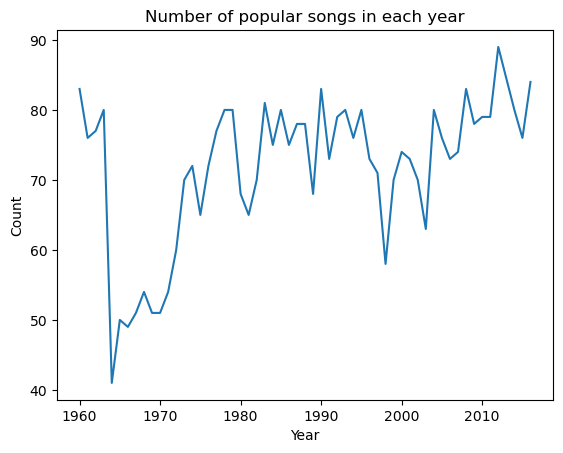

In [32]:
#Distribution of available song data in a given year from the time frame 1960-2017 
songsinyear_graph = sns.lineplot(countyear, x="Year", y="Count")
plt.title('Number of popular songs in each year')

# Cleaning Econ Data

#### Manipulating Econ Data and Handling Missing Values

We checked the Effective Federal Funds Rate for the number of data and checked to see if any missing values were present. 

In [33]:
fedFunds = pd.read_csv("FEDFUNDS.csv")
un = pd.read_csv("un.csv")
us_gdp_data = pd.read_csv("GDP.csv")
stocks = pd.read_csv("stocks_final.csv")
incar = pd.read_csv('incarceration.csv', skiprows=5, nrows=2)
death = pd.read_csv('death_rates.csv')
birth = pd.read_csv('birth_rate.csv',skiprows=4)

Note: For incar and birth, we had to skip rows or only select relevant rows since they weren't the same format or the same number of entries per column.

In [34]:
econdata = un.merge(fedFunds, how="left")
econdata

,DATE,UNRATE,FEDFUNDS
0,1948-01-01,3.4,NaN
1,1948-02-01,3.8,NaN
2,1948-03-01,4.0,NaN
3,1948-04-01,3.9,NaN
4,1948-05-01,3.5,NaN
...,...,...,...
916,2024-05-01,4.0,5.33
917,2024-06-01,4.1,5.33
918,2024-07-01,4.3,5.33
919,2024-08-01,4.2,5.33


In [35]:
# checking to see if we have NaN values
print("Number of rows in fed fund rate: ", \
      len(econdata['FEDFUNDS']))
print("Nan is present: ",\
      np.isnan(econdata['FEDFUNDS']).any())

Number of rows in fed fund rate:  921
Nan is present:  True


To avoid any potential problems with graphs down the line, we dropped all the NaN values. After dropping all the Nans from our dataset, we then checked to see how many data points are now there. 

In [36]:
#Nan vaue is found, drop it 
econdata.dropna(subset=['FEDFUNDS'], inplace=True)
print(np.isnan(econdata['FEDFUNDS']).any())
#check the shape to see if we have enough data
print(econdata.shape)


False
(843, 3)


We renamed the 'Effective Federal Funds Rate' column in econdata to 'fedfundrate' to simplify every time we have to refer to the specific column.

In [37]:
#rename the FEDFUNDS col, easier without space for writing SQL later
print(econdata.columns)
econdata.rename(columns={"FEDFUNDS": "fedfundrate"}, inplace=True)
print(econdata.columns)

Index(['DATE', 'UNRATE', 'FEDFUNDS'], dtype='object')
Index(['DATE', 'UNRATE', 'fedfundrate'], dtype='object')


Since the fed fund rate is updated on a monthly basis, we averaged the fed fund rate over a 12 month period to get the average yearly fed fund rate since we want to make it the equalize the time periods with musicdata.

#### Checking and Manipulating Unemployment Data 

We checked the Unemployment data for the number of data points that were there and also see if any missing values were present. 

In [38]:
# checking to see if we have NaN values
print("Number of rows in UNRate: ", len(econdata['UNRATE']))
print("Nan is present: ",\
      np.isnan(econdata['UNRATE']).any())

Number of rows in UNRate:  843
Nan is present:  False


We converted date to datetime to allow for a more comprehensive merge later on. 

In [39]:
# in order to merge the data, we need to convert the date format into datetime

#check date type
print(econdata["DATE"].dtype)
# convert to datetime format
econdata['DATE']= pd.to_datetime(econdata['DATE'], \
                               format='%Y-%m-%d', errors='coerce')


econdata['Year'] = econdata['DATE'].dt.year


econdata

object


,DATE,UNRATE,fedfundrate,Year
78,1954-07-01,5.8,0.80,1954
79,1954-08-01,6.0,1.22,1954
80,1954-09-01,6.1,1.07,1954
81,1954-10-01,5.7,0.85,1954
82,1954-11-01,5.3,0.83,1954
...,...,...,...,...
916,2024-05-01,4.0,5.33,2024
917,2024-06-01,4.1,5.33,2024
918,2024-07-01,4.3,5.33,2024
919,2024-08-01,4.2,5.33,2024


Since the unemployment rate data is given on a monthly scale, we averaged the 12-month unemployment to get a yearly average unemployment rate to allow the data to be merged with the Spotify dataset later on. 


In [40]:
# modify undata to find avg unrate for each year
econdata = duckdb.sql("""SELECT ANY_VALUE(Year) as Year, 
        AVG(UNRATE) AS UnemploymentRate, 
        AVG(fedfundrate) AS fedfundrate,     
        FROM econdata
        GROUP BY Year
        ORDER BY Year
        """).df()
econdata

,Year,UnemploymentRate,fedfundrate
0,1954,5.650000,1.008333
1,1955,4.366667,1.785000
2,1956,4.125000,2.728333
3,1957,4.300000,3.105000
4,1958,6.841667,1.572500
...,...,...,...
66,2020,8.091667,0.375833
67,2021,5.350000,0.080000
68,2022,3.633333,1.683333
69,2023,3.625000,5.024167


#### Renaming US GDP 
rename US GDP col for easier reference and also made sure it was a datetime object with Yearly units:

In [41]:
us_gdp_data = us_gdp_data.rename(columns={"GDP": "US_GDP"})
us_gdp_data['DATE']= pd.to_datetime(us_gdp_data['DATE'], \
                               format='%Y-%m-%d', errors='coerce')
us_gdp_data['Year'] = us_gdp_data['DATE'].dt.year
us_gdp_data

,DATE,US_GDP,Year
0,1947-01-01,243.164,1947
1,1947-04-01,245.968,1947
2,1947-07-01,249.585,1947
3,1947-10-01,259.745,1947
4,1948-01-01,265.742,1948
...,...,...,...
305,2023-04-01,27453.815,2023
306,2023-07-01,27967.697,2023
307,2023-10-01,28296.967,2023
308,2024-01-01,28624.069,2024


Only having one Year column for US GDP:

In [42]:
gdp = duckdb.sql("""
    SELECT 
        ANY_VALUE(Year) as Year, 
        AVG(US_GDP) AS US_GDP, 
    FROM 
        us_gdp_data
    GROUP BY 
        Year
    ORDER BY 
        Year
""").df()

gdp

,Year,US_GDP
0,1947,249.61550
1,1948,274.46775
2,1949,272.47525
3,1950,299.82725
4,1951,346.91325
...,...,...
73,2020,21354.10475
74,2021,23681.17075
75,2022,26006.89250
76,2023,27720.70950


#### Merging US GDP with the other econ data

In [43]:
econdata = duckdb.sql(""" SELECT Econdata.Year, UnemploymentRate, fedfundrate, gdp.US_GDP 
                            FROM econdata 
                            INNER JOIN gdp 
                            ON Econdata.Year = GDP.Year""").df() 

econdata

,Year,UnemploymentRate,fedfundrate,US_GDP
0,1954,5.650000,1.008333,390.54900
1,1955,4.366667,1.785000,425.47950
2,1956,4.125000,2.728333,449.35250
3,1957,4.300000,3.105000,474.03950
4,1958,6.841667,1.572500,481.22850
...,...,...,...,...
66,2022,3.633333,1.683333,26006.89250
67,2023,3.625000,5.024167,27720.70950
68,2024,4.000000,5.307778,28820.39150
69,1973,4.858333,8.727500,1425.37600


#### Merging above econ data with music data and historical event


Next, we merged all of the data frames together to create one comprehensive overview of all the present information. We merged the data frame with the music sentiment(danceability, valence, year) with the fedfundrate dataframe, unemploymentRate dataframe, and the GDP dataframe. This allows us to see how certain economic metrics affect the music sentiment shared by the general public. 

In [44]:
# use sql to get a data frame with danceabilty, valence, interest rate and unemployment
cleandata= duckdb.sql("""SELECT danceability,valence, 
            newmusicdata.Year AS year, fedfundrate, UnemploymentRate, recession, election, US_GDP
            FROM newmusicdata INNER JOIN econdata ON 
            newmusicdata.Year = econdata.Year""").df()
cleandata

,danceability,valence,year,fedfundrate,UnemploymentRate,recession,election,US_GDP
0,0.325,0.9130,1960,3.215833,5.541667,1,1,542.38225
1,0.533,0.1905,1960,3.215833,5.541667,1,1,542.38225
2,0.498,0.8660,1960,3.215833,5.541667,1,1,542.38225
3,0.447,0.3300,1960,3.215833,5.541667,1,1,542.38225
4,0.558,0.3030,1960,3.215833,5.541667,1,1,542.38225
...,...,...,...,...,...,...,...,...
4000,0.812,0.7205,1991,5.687500,6.850000,1,0,6158.12925
4001,0.676,0.8180,1991,5.687500,6.850000,1,0,6158.12925
4002,0.363,0.3170,1991,5.687500,6.850000,1,0,6158.12925
4003,0.899,0.9730,1991,5.687500,6.850000,1,0,6158.12925


## Adding more Economic variables
### Cleaning the Stock raw file
We first changed the Year column to datetime Year format, then we converted the stock values to floats. This way, our data would be in the format ready to merge. 

In [45]:
stocks['Year'] = pd.to_datetime(stocks['Year'], format='%Y')
stocks['Year'] = stocks['Year'].dt.year
stocks['S&P500'] = stocks['S&P500'].astype(float)

stocks.head()

,Year,S&P500
0,1928,0.44
1,1929,-0.08
2,1930,-0.25
3,1931,-0.44
4,1932,-0.09


### Cleaning the incarceration rate data
First we switched the rows and columns since the raw data had the year as columns names and state prison rate and other incarceration statistics as rows. However, we are only interested in the state prison population. Then, we made sure the date was in datetime object with Yearly units and converted the incarceration values to floats to be ready to merge. 

In [46]:
incar = incar.transpose() #switch row and column
incar.columns = incar.iloc[0] # Reset index 
incar = incar[1:]
incar.columns = ['year', 'State prisons']
incar['year'] = incar['year'].astype(int)
incar['year'] = pd.to_datetime(incar['year'], format='%Y')
incar['year'] = incar['year'].dt.year
incar['State prisons'] = incar['State prisons'].astype(float)

incar.reset_index(drop=True, inplace=True) # Reset the index
incar.head()

,year,State prisons
0,1925,85239.0
1,1926,91188.0
2,1927,101624.0
3,1928,108157.0
4,1929,107532.0


### Cleaning the death rate data
After seeing the raw data, we wanted the category with both sexes included. Then, we ran into a warning comment that directed us to copy the data (see reference). Then, we made sure the data was comparable with datetime object Yearly units and float death rates. 

In [47]:
both_sexes = death[death['Sex'] == 'Both Sexes']
death = both_sexes[['Year', 'Age-adjusted Death Rate']].copy()
death['Age-adjusted Death Rate'] = death['Age-adjusted Death Rate'].str.replace(',', '').astype(float)
death['Year'] = death['Year'].astype(int)
death['Year'] = pd.to_datetime(death['Year'], format='%Y')
death['Year'] = death['Year'].dt.year

death.head(100)

,Year,Age-adjusted Death Rate
0,1900,2518.0
1,1901,2473.1
2,1902,2301.3
3,1903,2379.0
4,1904,2502.5
...,...,...
95,1995,909.5
96,1996,893.7
97,1997,877.7
98,1998,870.1


### Cleaning the birth rate data
After seeing the raw data, we wanted the only look into the US birth rate and picked out the year range comparable to our other data. Then, we switched the rows and columns using transpose and index reste (see reference). Then, we made sure the data was comparable with datetime object Yearly units and float birth rates. 

In [48]:
birth = birth[birth['Country Name'] == 
'United States'][['Country Name', 'Indicator Name'] + [str(year) for year in range(1960, 2023)]]

birth = birth.set_index(['Country Name', 'Indicator Name']).T.reset_index()
birth.columns = ['year', 'fertility']
birth['year'] = pd.to_datetime(birth['year'], format='%Y')
birth['fertility'] = birth['fertility'].astype(float)
birth['year'] = birth['year'].dt.year
birth.to_csv('cleaned_birth_rate_us.csv', index=False)

birth.head()

,year,fertility
0,1960,3.654
1,1961,3.620
2,1962,3.461
3,1963,3.319
4,1964,3.190


### Combining newly added econ data
we merges incarceration rates, birth rates, death rates, and stock prices into a dataframe. 

In [49]:
var = incar.merge(birth, how="left")
death = death.rename(columns={'Year': 'year'})
stocks = stocks.rename(columns={'Year': 'year'})

var = var.merge(death, how="left")
var = var.merge(stocks, how="left")
var = var.drop_duplicates(subset='year', keep='first')
var = var[35:].reset_index()
var = var.drop('index', axis=1)
var

,year,State prisons,fertility,Age-adjusted Death Rate,S&P500
0,1960,189735.0,3.6540,1339.2,0.00
1,1961,196453.0,3.6200,1298.8,0.27
2,1962,194886.0,3.4610,1323.6,-0.09
3,1963,194155.0,3.3190,1346.3,0.23
4,1964,192627.0,3.1900,1303.8,0.16
...,...,...,...,...,...
58,2018,1249717.0,1.7295,723.6,-0.04
59,2019,1221288.0,1.7060,NaN,0.31
60,2020,1043705.0,1.6415,NaN,0.18
61,2021,1021288.0,1.6640,NaN,0.28


We then renamed columns for easier access and readability:

In [50]:
var.rename(columns={"State prisons": "State_prisons"}, inplace=True)
var.rename(columns={"Age-adjusted Death Rate": "DeathRate"}, inplace=True)
var.columns

Index(['year', 'State_prisons', 'fertility', 'DeathRate', 'S&P500'], dtype='object')

## Bringing it All Together
We merged the newly added econ data into our original music and econ data.

In [51]:
cleandata = duckdb.sql("SELECT *\
        FROM cleandata INNER JOIN var\
        ON cleandata.year = var.year").df()
cleandata

,danceability,valence,year,fedfundrate,UnemploymentRate,recession,election,US_GDP,year_1,State_prisons,fertility,DeathRate,S&P500
0,0.325,0.9130,1960,3.215833,5.541667,1,1,542.38225,1960,189735.0,3.6540,1339.2,0.0
1,0.533,0.1905,1960,3.215833,5.541667,1,1,542.38225,1960,189735.0,3.6540,1339.2,0.0
2,0.498,0.8660,1960,3.215833,5.541667,1,1,542.38225,1960,189735.0,3.6540,1339.2,0.0
3,0.447,0.3300,1960,3.215833,5.541667,1,1,542.38225,1960,189735.0,3.6540,1339.2,0.0
4,0.558,0.3030,1960,3.215833,5.541667,1,1,542.38225,1960,189735.0,3.6540,1339.2,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4000,0.812,0.7205,1991,5.687500,6.850000,1,0,6158.12925,1991,732916.0,2.0625,921.9,0.3
4001,0.676,0.8180,1991,5.687500,6.850000,1,0,6158.12925,1991,732916.0,2.0625,921.9,0.3
4002,0.363,0.3170,1991,5.687500,6.850000,1,0,6158.12925,1991,732916.0,2.0625,921.9,0.3
4003,0.899,0.9730,1991,5.687500,6.850000,1,0,6158.12925,1991,732916.0,2.0625,921.9,0.3


Finally, we wanted to double check is the columns were all the variables we wanted, which it is:

In [52]:
cleandata.columns

Index(['danceability', 'valence', 'year', 'fedfundrate', 'UnemploymentRate',
       'recession', 'election', 'US_GDP', 'year_1', 'State_prisons',
       'fertility', 'DeathRate', 'S&P500'],
      dtype='object')

After cleaning, we convert this to a CSV file named "final_clean_data.csv"

In [53]:
cleandata.to_csv("final_clean_data.csv")

### Reference
1. Stack Overflow. "Seaborn Plot with Second Y-Axis." *Stack Overflow*, 12 Apr. 2019, https://stackoverflow.com/questions/55654500/seaborn-plot-with-second-y-axis.

2. Stack Overflow. "How to Deal with SettingWithCopyWarning in Pandas." *Stack Overflow*, 11 Nov. 2013, https://stackoverflow.com/questions/20625582/how-to-deal-with-settingwithcopywarning-in-pandas.

3. "pandas.DataFrame.reset_index." *Pandas Documentation*, https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.reset_index.html.

4. Stack Overflow. "How Do I Transpose DataFrame in Pandas without Index?" *Stack Overflow*, 12 Apr. 2017, https://stackoverflow.com/questions/42381639/how-do-i-transpose-dataframe-in-pandas-without-index